### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import os
import pickle

# for clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# for map with HRU boundaries and budyko plot
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go

In [38]:
# table plotting style settings and functions

cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': [('background-color', '#ffffb3')]}

def highlight_max(x):
    return ['background-color: #e6ffe6' if v == x.max() else '' for v in x]
def highlight_min(x):
    return ['background-color: #ffe6e6 ' if v == x.min() else '' for v in x]

### Loading hydrological signature, CAMELS attributes and scaling
1. list of catchments
2. hydrologcial signatures (CAMELS US dataset)
3. HRU number (CAMELS US dataset)
4. attributes (CAMELS US dataset)
5. scaling of attributes (-mean / std)

In [5]:
# 1. List of 516 CAMELS US catchments (with hourly Qobs available)
with open('data/516_basins.txt', 'r') as f:
    basin_list = [line.rstrip() for line in f]
    f.close()
# basin_list

In [8]:
# 2. Load hydrological signatures from Camels US dataset (for Budyko plot)
hydrol_attrib = pd.read_csv('data/camels_attributes/camels_hydro.txt', sep=';', dtype={'gauge_id': str})
hydrol_attrib.index = hydrol_attrib.gauge_id
hydrol_attrib = hydrol_attrib.drop('gauge_id', axis=1)
hydrol_attrib = hydrol_attrib.loc[hydrol_attrib.index.isin(basin_list)]
# hydrol_attrib

In [12]:
# 3. Load HRU associated with each catchment
huc_df = pd.read_csv('data/camels_attributes/camels_name.txt', header=0, dtype={'gauge_id': str, 'huc_02': str}, sep=';')
huc_df.index = huc_df.gauge_id
huc_df = huc_df.drop(columns='gauge_id')
huc_df = huc_df.loc[huc_df.index.isin(basin_list)]
# huc_df

In [9]:
# 4. Load Camels US attribtes (27 attributes)
attributes_df = pd.read_csv('data/camels_attributes/camels_attributes.csv', header=0, dtype={'basin': str})
attributes_df.index = attributes_df.basin
attributes_df = attributes_df.drop(columns='basin')
attributes_df = attributes_df.loc[attributes_df.index.isin(basin_list)]

# HydroMT attributes to select same 21 columns (attributes) in Camels US dataset
attributes_df_hydro = pd.read_csv('data/hydromt_attributes/ubasin_us.csv', header=0, dtype={'hru_id': str})
attributes_df_hydro = attributes_df_hydro.rename(columns= {'hru_id': 'basin', 
                                                           'area_km2': 'area_gages2', 
                                                           'soil_thickness': 'soil_depth_statsgo',
                                                           'ksatver_logmean': 'soil_conductivity',
                                                           'theta_s': 'max_water_content'})
attributes_df_hydro.index = attributes_df_hydro.basin
attributes_df_hydro = attributes_df_hydro.drop(columns='basin')
attributes_df = attributes_df[attributes_df_hydro.columns]


In [10]:
# create dictionarry with names and units for plots and axis labels
attribute_names = ['Mean precipitation', 'Aridity', 'Area', 'Mean elevation', 'High precip. duration', 'Fraction of snow', 
              'High precip. frequency', 'Mean slope', 'Geological permeability', 'Frac. of carbonate sedimentary rock', 
              'Clay fraction', 'Mean PET', 'Low precip. frequency', 'Soil depth to bedrock', 'Precip. seasonality',
              'Frac. of forest', 'Sand fraction', 'Saturated hyd. conductivity', 'Low precip. duration',
              'Max. green veg. frac. (GVF)', 'Annual GVF diff.', 'LAI diff.', 'Volumetric porosity', 'Soil depth', 
              'Max. LAI', 'Silt fraction', 'Max. water content', 'HRU']
units = ['mm/d', '-', 'km2', 'masl', 'd', '-', 'd/a', 'm/km', 'm2', '-',
        '%', 'mm/d', 'd/a', 'm', '-', '-', '%', 'cm/h', 'd', '-', 
        '-', '-', '-', 'm', '-', '%', 'm', 'HUC']

name_unit_dict = {}

for i, col in enumerate(attributes_df.columns):
    name_unit_dict[col] = {}
    name_unit_dict[col]['name'] = attribute_names[i]
    name_unit_dict[col]['unit'] = units[i]
    
name_unit_dict.keys()

dict_keys(['area_gages2', 'geol_permeability', 'soil_porosity', 'carb_rocks_frac', 'elev_mean', 'slope_mean', 'gvf_max', 'gvf_diff', 'lai_diff', 'lai_max', 'p_mean', 'pet_mean', 'aridity', 'high_prec_dur', 'low_prec_dur', 'high_prec_freq', 'low_prec_freq', 'frac_snow_daily', 'soil_depth_statsgo', 'soil_conductivity', 'max_water_content'])

In [11]:
# 5. Scale Camels US attributes as preparation for clustering
scaler = StandardScaler()
scaled_attributes = scaler.fit_transform(attributes_df.values)
scaled_df = pd.DataFrame(data=scaled_attributes, columns=attributes_df.columns, index=attributes_df.index)

basins = attributes_df.index.tolist()

# scaled_df.head()

### Silhoutte coefficient

To determine optimal number of clusters.

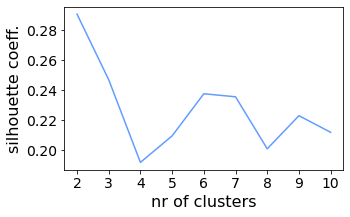

In [13]:
kmeans_kwargs = {
    'init': 'k-means++',
    'n_init': 10,
    'max_iter': 300, 
    'random_state': 42
}

silhouette_coeffs = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_attributes)
    score = silhouette_score(scaled_attributes, kmeans.labels_)
    silhouette_coeffs.append(score)
    
fig = plt.figure(figsize=(5, 3))
plt.plot(range(2, 11), silhouette_coeffs, color='#619cff')
plt.xticks(range(2, 11), fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('nr of clusters', fontsize=16)
plt.ylabel('silhouette coeff.', fontsize=16)
plt.show()

### k-means Clustering

Into 6 and 7 clusters, as silhouette score for both is highest (when not considering to have only 2 clusters).

Attention: cluster numbers reach from 0 to 5 (6).

In [15]:
k_list = [6, 7]

predictions = {}
basins_in_cluster = {}

for k in k_list:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs).fit(scaled_attributes)
    data =  kmeans.predict(scaled_df.values)
    
    predictions_df = pd.DataFrame(data=data, index=attributes_df.index.values)
    predictions_df.rename(columns = {0: 'cluster'}, inplace = True)
    predictions[k] = predictions_df
    
    basins_in_cluster[k] = {}
    print(f'with k={k} clusters:\n{predictions[k].cluster.value_counts()}')
    
    for cluster in range(k):
        basins_in_cluster[k][str(cluster)] = predictions_df.loc[predictions_df.cluster == cluster].index.values
        
with open('data/basins_in_cluster_camels.p', 'wb') as f:
    pickle.dump(basins_in_cluster, f, protocol=pickle.DEFAULT_PROTOCOL)

with k=6 clusters:
5    164
2    101
3     73
0     66
4     58
1     54
Name: cluster, dtype: int64
with k=7 clusters:
2    164
4     89
0     67
6     58
3     54
1     46
5     38
Name: cluster, dtype: int64


In [39]:
# Cluster centers (mean attribute value per cluster) when building 7 clusters.
cluster_centers_df = pd.DataFrame(data=scaler.inverse_transform(kmeans.cluster_centers_), 
                                  columns=attributes_df.columns, 
                                  index=np.arange(1,8,1))
cluster_centers_df.index.rename('Cluster Nr.', inplace=True)
cluster_centers_df.style.format('{:.2f}')\
                    .apply(highlight_max)\   # green
                    .apply(highlight_min)\   # red
                    .set_table_styles([cell_hover])


,area_gages2,geol_permeability,soil_porosity,carb_rocks_frac,elev_mean,slope_mean,gvf_max,gvf_diff,lai_diff,lai_max,p_mean,pet_mean,aridity,high_prec_dur,low_prec_dur,high_prec_freq,low_prec_freq,frac_snow_daily,soil_depth_statsgo,soil_conductivity,max_water_content
Cluster Nr.,,,,,,,,,,,,,,,,,,,,,
1,597.18,-13.27,0.42,0.05,92.96,5.31,0.77,0.25,2.61,3.80,3.74,3.32,0.89,1.27,5.14,22.48,261.11,0.02,1.50,3.20,0.61
2,840.44,-13.74,0.44,0.03,853.56,19.82,0.52,0.24,0.93,1.35,1.84,3.11,1.78,1.46,8.43,25.72,297.81,0.11,1.41,1.14,0.57
3,405.03,-14.65,0.44,0.05,508.02,40.68,0.87,0.46,4.09,4.77,3.57,2.49,0.71,1.20,3.82,19.50,233.90,0.15,1.25,1.52,0.53
4,292.31,-13.78,0.43,0.07,2530.78,111.25,0.55,0.22,1.11,1.67,2.42,3.01,1.36,1.45,6.29,18.95,254.53,0.64,1.25,2.01,0.47
5,540.21,-13.73,0.47,0.41,323.52,9.58,0.73,0.47,2.25,2.61,2.89,2.59,0.92,1.25,4.96,23.13,264.15,0.09,1.41,0.93,0.64
6,533.40,-13.40,0.44,0.36,903.94,63.22,0.55,0.13,0.96,1.83,2.23,3.37,1.73,1.62,11.27,25.35,301.52,0.09,0.84,1.30,0.29
7,365.53,-13.71,0.44,0.00,719.09,111.64,0.84,0.18,2.34,4.03,6.27,2.30,0.39,1.55,5.58,13.81,200.56,0.19,1.24,1.65,0.46


### Plotting clusters on map

In [40]:
# load HRU shape files

map_df = gpd.read_file('data\HUC_shapes\wbdhu2_fixed_geom\wbdhu2_fixed_geom.shp')
# hucs from 1..18 are CONUS, huc >18 is Alaska and islands
hucs = sorted(map_df.huc2.unique())[:-4]
map_df_sub = map_df.loc[map_df.huc2.isin(hucs)]

# load lat lon gauge data from Camels US dataset
loc_df = pd.read_csv('data/camels_attributes/camels_topo.txt', 
                     sep=';', 
                     header=0, 
                     dtype={'gauge_id': str})\
                    .set_index('gauge_id')

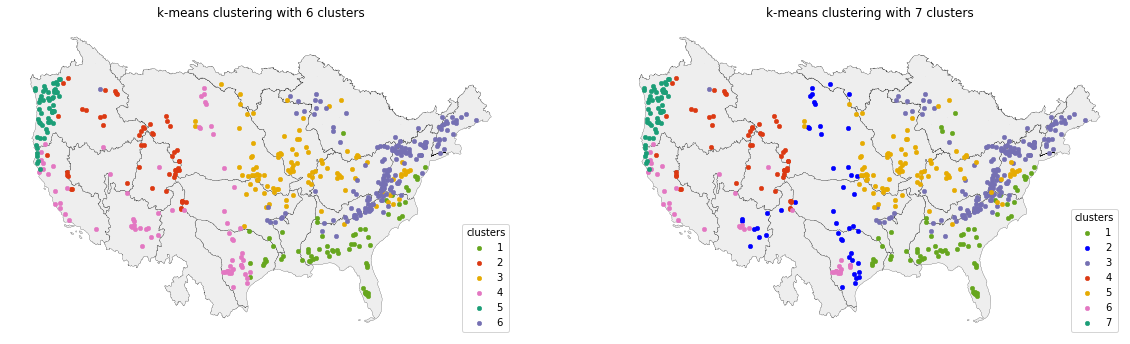

In [55]:
# to ensure same colors for clusters with similar geographic location
color_list_6 = ['#66a61e', '#DC3912', '#e6ab02', '#e377c2', '#1b9e77', '#7570b3', 'navy']
color_list_7 = ['#66a61e', 'blue', '#7570b3', '#DC3912', '#e6ab02', '#e377c2', '#1b9e77']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

for i, k in enumerate(k_list):
    if k==6: 
        color_list = color_list_6
    elif k==7:
        color_list = color_list_7

    map_df_sub.plot(ax=ax[i], facecolor='#eeeeee', edgecolor='black', linewidth=0.2)

    for cluster, basins in basins_in_cluster[k].items():
        data = {'lat': [], 'lon': [], 'color': []}
        data["lat"].append(loc_df.loc[loc_df.index.isin(basins), 'gauge_lat'][:])
        data["lon"].append(loc_df.loc[loc_df.index.isin(basins), 'gauge_lon'][:])
        data["color"].append(color_list[int(cluster)])
        
        label = int(cluster) + 1
        points = ax[i].scatter(x=data["lon"],
                                 y=data["lat"],
                                 c=data["color"],
                                 s=20, 
                                 zorder=2,
                                 linewidth=0.5,
                                 label = str(label))
    ax[i].axis(False)
    ax[i].set_title(f'k-means clustering with {k} clusters')
    ax[i].legend(loc='lower right', title='clusters')

plt.savefig('plots/k-means_maps_camels.png')
plt.show()


### Budyko curve
#### Preparation

In [49]:
# budyko curve x and y values
PET_P = np.arange(0.001, 5.5, 0.05)   # x-axis
ET_P = (PET_P * np.tanh(1 / PET_P) * (1 - np.exp(-PET_P))) ** 0.5   # y-axis

# water limit
water_limit_x = PET_P[PET_P > 1]
water_limit_y = 1 + water_limit_x * 0

# energy limit
energy_limit_x = np.arange(0, 1.0001, 0.05)
energy_limit_y = energy_limit_x


# combine cluster info with attributes and hydrol signatures
k = 7 # nr of clusters
budyko_df = pd.concat([predictions[k], attributes_df, hydrol_attrib], join='inner', axis=1)

# get x and y values for each catchment
budyko_df['PET/P'] = budyko_df['pet_mean'] / (budyko_df['p_mean'])
budyko_df['ET/P'] = 1 - budyko_df['q_mean'] / (budyko_df['p_mean'])

# add 'cluster' as str in dataframe, add column with gauge id for hover text, sort by cluster
budyko_df['Cluster'] = (budyko_df.cluster + 1).astype(str)
budyko_df['gauge_id'] = budyko_df.index
budyko_df['huc_02'] = huc_df['huc_02']
budyko_df = budyko_df.sort_values(by='cluster', axis=0)
budyko_df.head()

,cluster,area_gages2,geol_permeability,soil_porosity,carb_rocks_frac,elev_mean,slope_mean,gvf_max,gvf_diff,lai_diff,...,high_q_dur,low_q_freq,low_q_dur,zero_q_freq,hfd_mean,PET/P,ET/P,Cluster,gauge_id,huc_02
02479155,0,137.279999,-11.6529,0.415527,0.0,70.209999,6.65609,0.847353,0.149711,2.573584,...,2.000000,108.95,10.327014,0.0,156.70,0.722637,0.661249,1,02479155,03
02361000,0,1781.609985,-14.2703,0.408212,0.0,117.139999,8.27039,0.718239,0.272116,2.133473,...,2.547619,55.30,12.712644,0.0,164.35,0.831366,0.693253,1,02361000,03
03592718,0,66.989998,-12.7422,0.432058,0.0,173.220001,6.67758,0.822930,0.384213,3.361376,...,1.525316,79.75,9.906832,0.0,150.25,0.879720,0.647888,1,03592718,06
02053200,0,583.659973,-13.0346,0.419121,0.0,25.280001,2.20328,0.772461,0.345753,2.472521,...,6.696078,154.25,21.725352,0.0,174.95,0.838932,0.742582,1,02053200,03
02363000,0,1292.510010,-13.1690,0.415416,0.0,135.389999,7.57689,0.774038,0.283772,2.768642,...,3.900000,111.55,17.991935,0.0,163.00,1.053256,0.726173,1,02363000,03


In [53]:
size_attribute = 'elev_mean'   # can be any other column of budyko_df i.e. q_mean, area_gages2, elev_mean, Q5, Q95, 
size_name = 'mean elevation'
size_unit = 'm'                # high_flow_freq, high_flow_dur, frac_snow_daily, ...

fig = px.scatter(budyko_df, 
                 x = "PET/P", 
                 y = "ET/P", 
                 size=size_attribute,
                 hover_name=budyko_df.index, #'gauge_id',
                 custom_data=['gauge_id', 'Cluster', 'area_gages2', 'frac_snow_daily', 'q_mean', 'elev_mean', 
                              'hfd_mean', 'huc_02'],
                 color = "Cluster", 
                 color_discrete_map={
                    "1": "#66a61e",
                    "2": "blue",
                    "3": "#7570b3",
                    "4": "#DC3912",
                    "5": "#e6ab02",
                    "6": "#e377c2",
                    "7": "#1b9e77"},
                )


fig.update_traces(hovertemplate='<br>'.join([
                        "catchment: %{customdata[0]} - huc: %{customdata[7]}",
                        "cluster: %{customdata[1]}",
                        "Qmean: %{customdata[4]:.2f} mm/d",
                        "Evlev. mean: %{customdata[5]:.2f m}",
                        "HFD mean: day %{customdata[6]:.2f}"])
                 )

fig.add_trace(go.Scatter(x=PET_P,
                         y=ET_P,
                         mode='lines',
                         name='Budyko curve',
                         marker_color='#0D2A63'))

fig.add_trace(go.Scatter(x=energy_limit_x,
                         y=energy_limit_y,
                         mode='lines',
                         name='Energy limit',
                         marker_color='#D62728'))

fig.add_trace(go.Scatter(x=water_limit_x,
                         y=water_limit_y,
                         mode='lines',
                         name='Water limit',
                         marker_color='blue'))

fig.add_vline(x=1,
             line_dash='dash',
             line_width=1)
fig.add_hline(y=0,
             line_dash='dash',
             line_width=1)

fig.update_xaxes(showspikes=True, spikethickness=1, 
                    linecolor='black',
                    linewidth=2,
                    mirror=True,
                    tickfont = {"size": 20},
                    title_font = {"size": 20})

fig.update_yaxes(showspikes=True, spikethickness=1, 
                    linecolor='black',
                    linewidth=2,
                    mirror=True,
                    tickfont = {"size": 20},
                    title_font = {"size": 20})

fig.update_layout(title_text=f'Size of markers corresponds to {size_name} [{size_unit}] per catchment',
                    paper_bgcolor='white', plot_bgcolor='white',
                    legend=dict(
                        yanchor="bottom",
                        y=0.01,
                        xanchor="right",
                        x=0.99,
                        font={'size': 15},
                    bordercolor="Black",
                    borderwidth=2))

fig.show();

### Checking iregularities in budyko frame
negative values in ET/P means higher discharge than precipitation (longterm mean) which is an indicator for storage release, i.e. snow/glacier melt 

For which catchments is this the case?

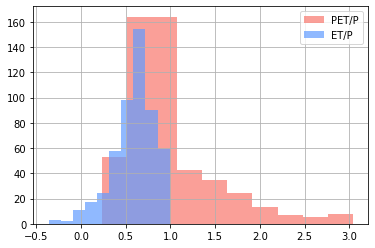

catchments with negative ET/P: Index(['06746095', '12040500', '12041200', '12054000', '12056500', '12167000',
       '12175500', '12178100', '12186000', '12147500', '14400000'],
      dtype='object')


In [54]:
colors = ['#f8766d', '#619cff'] # #00ba38 (red, blue, green)

fig = plt.figure()
ax = plt.subplot(111)
budyko_df['PET/P'].hist(ax=ax, label='PET/P', alpha=0.7, color=colors[0])
budyko_df['ET/P'].hist(ax=ax, label='ET/P', alpha=0.7, color=colors[1])
plt.legend()
plt.show()

neg_ET_P = budyko_df.loc[budyko_df['ET/P'] < 0].index
print(f'catchments with negative ET/P: {neg_ET_P}') 

#### Plotting map of basins with negative ET/P


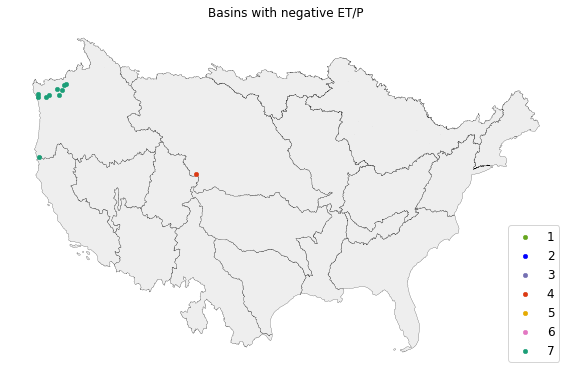

In [48]:
basins_neg = ['06746095', '12040500', '12041200', '12054000', '12056500', '12167000', '12175500', '12178100', '12186000', '12147500', '14400000']

color_list_7 = ['#66a61e', 'blue', '#7570b3', '#DC3912', '#e6ab02', '#e377c2', '#1b9e77']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
map_df_sub.plot(ax=ax, facecolor='#eeeeee', edgecolor='black', linewidth=0.2)

for cluster, basins in basins_in_cluster[7].items():
    data = {'lat': [], 'lon': [], 'color': []}
    basins_n = []
    for b in basins:
        if b in basins_neg:
            basins_n.append(b)
    data["lat"].append(loc_df.loc[loc_df.index.isin(basins_n), 'gauge_lat'][:])
    data["lon"].append(loc_df.loc[loc_df.index.isin(basins_n), 'gauge_lon'][:])
    data["color"].append(color_list_7[int(cluster)])

    label = int(cluster) + 1
    points = ax.scatter(x=data["lon"],
                             y=data["lat"],
                             c=data["color"],
                             s=20, 
                             zorder=2,
                             linewidth=0.5,
                             label = str(label))
ax.axis(False)
ax.set_title('Basins with negative ET/P')
ax.legend(loc='lower right', fontsize=12)
plt.savefig('plots/basins_negative_ET_P.png')
plt.show()


### Plotting map of  basins without straemflow records in training period
basin IDs taken from output log when training MTS-LSTM

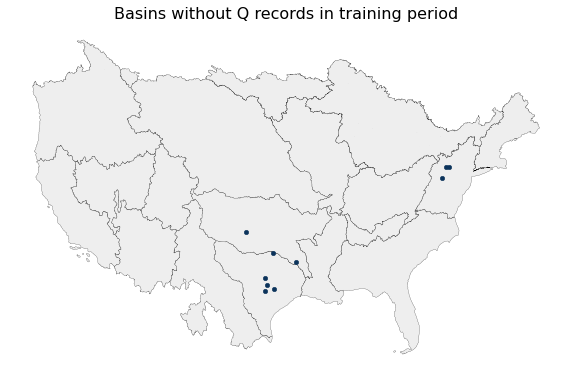

In [46]:
basins_noQ = ['01552000', '01552500', '01567500', '07301410', '07346045', 
       '08050800', '08101000', '08104900', '08109700', '08158810']

color_list_6 = ['#66a61e', '#DC3912', '#e6ab02', '#e377c2', '#1b9e77', '#7570b3', 'navy']
color_list_7 = ['#66a61e', 'blue', '#7570b3', '#DC3912', '#e6ab02', '#e377c2', '#1b9e77']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,7))

map_df_sub.plot(ax=ax, facecolor='#eeeeee', edgecolor='black', linewidth=0.2)

data = {'lat': [], 'lon': [], 'color': []}
data["lat"].append(loc_df.loc[loc_df.index.isin(basins_noQ), 'gauge_lat'][:])
data["lon"].append(loc_df.loc[loc_df.index.isin(basins_noQ), 'gauge_lon'][:])
data["color"].append('#0B335B')

points = ax.scatter(x=data["lon"],
                         y=data["lat"],
                         c=data["color"],
                         s=20, 
                         zorder=2,
                         linewidth=0.5,
                         label = str(label))
ax.axis(False)
ax.set_title('Basins without Q records in training period', fontsize=16)

plt.savefig('plots/basins_without_Q.png')
plt.show()
